In [1]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
import torch
import torch_geometric as tg
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from torch.utils.data import DataLoader
from torch_geometric_temporal import temporal_signal_split
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import utils
import torch.nn as nn
import torch.nn.functional as F
from typing import Union, Callable, Optional
import torch.optim as optim
import time

/home/joshi.at/.conda/envs/dl_project3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data was normalized via Z-Score method with mean = [53.59967    0.4982691] and std = [20.209862    0.28815305]


In [2]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", train_dataset.snapshot_count)
print("Number of test buckets: ", test_dataset.snapshot_count)

Number of train buckets:  27399
Number of test buckets:  6850


In [3]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [4]:
device = torch.device('cuda') # cuda
# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [5]:
def evaluation(model, eval_dataset):
    model.eval()
    loss = 0
    step = 0
    loss_mae = 0
    horizon = 1000

    # Store for analysis
    predictions = []
    labels = []

    for snapshot in eval_dataset:
        x = snapshot.x.to(device)
        #snapshot = snapshot.to(device)
        edge_indexes = snapshot.edge_index.to(device)
        y = snapshot.y.to(device)
        # Get predictions
        y_hat = model(x, edge_indexes)
        # Mean squared error
        loss = loss + torch.mean((y_hat-y)**2)
        loss_mae += torch.mean(torch.abs(y_hat-y))
        # Store for analysis below
        labels.append(y)
        predictions.append(y_hat)
        step += 1
        if step > horizon:
              break

    loss = loss / (step+1)
    loss_mae /= (step+1)
    loss = loss.item()
    loss_mae = loss_mae.item
    #print("Test MSE: {:.4f}".format(loss))
    model.train()
    return loss, predictions, labels
    #print("Test MAE: {:.4f}".format(loss_mae))

In [7]:
# GPU support
subset = 4000
model.train()
EPOCHS=60
print("Running training...")
start = time.time()
for epoch in range(EPOCHS): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        x = snapshot.x.to(device)
        edge_indexes = snapshot.edge_index.to(device)
        y = snapshot.y.to(device)
        #snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(x, edge_indexes)
        # Mean squared error
        loss += torch.mean((y_hat-y)**2)
        step += 1
        if step > subset:
          break
        del y_hat
        del edge_indexes
        del x
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_eval,_,_ = evaluation(model, test_dataset[2000:3000])
    loss_eval = loss_eval*20.209+53.59
    train_mse = loss*20.209+53.59
    print("Train MSE = {:.4f} Val MSE = {:.4f}".format(train_mse, loss_eval))
    #print("time running: {}".format(time.time()-start))
    del loss
    del loss_eval

Running training...
Train MSE = 69.0230 Val MSE = 65.4846
Train MSE = 68.1071 Val MSE = 65.0734
Train MSE = 67.2122 Val MSE = 64.7451
Train MSE = 66.4137 Val MSE = 64.5477
Train MSE = 65.7800 Val MSE = 64.5088
Train MSE = 65.3601 Val MSE = 64.6160
Train MSE = 65.1647 Val MSE = 64.8077
Train MSE = 65.1546 Val MSE = 65.0025
Train MSE = 65.2510 Val MSE = 65.1267
Train MSE = 65.3530 Val MSE = 65.1337
Train MSE = 65.3797 Val MSE = 65.0270
Train MSE = 65.3163 Val MSE = 64.8452
Train MSE = 65.1929 Val MSE = 64.6344
Train MSE = 65.0490 Val MSE = 64.4321
Train MSE = 64.9170 Val MSE = 64.2617
Train MSE = 64.8163 Val MSE = 64.1341
Train MSE = 64.7529 Val MSE = 64.0497
Train MSE = 64.7221 Val MSE = 64.0020
Train MSE = 64.7145 Val MSE = 63.9809
Train MSE = 64.7188 Val MSE = 63.9748
Train MSE = 64.7236 Val MSE = 63.9727
Train MSE = 64.7195 Val MSE = 63.9661
Train MSE = 64.7004 Val MSE = 63.9503
Train MSE = 64.6645 Val MSE = 63.9248
Train MSE = 64.6146 Val MSE = 63.8938
Train MSE = 64.5575 Val MSE = 

In [8]:
model.eval()
loss = 0
step = 0
loss_mae = 0
horizon = 1000

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset[2350:3000]:
    x = snapshot.x.to(device)
    #snapshot = snapshot.to(device)
    edge_indexes = snapshot.edge_index.to(device)
    y = snapshot.y.to(device)
    # Get predictions
    y_hat = model(x, edge_indexes)
    # Mean squared error
    loss = loss + torch.mean((y_hat-y)**2)
    loss_mae += torch.mean(torch.abs(y_hat-y))
    # Store for analysis below
    labels.append(y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss_mae /= (step+1)
loss = loss.item()
loss_mae = loss_mae.item()
#print("Test MSE: {:.4f}".format(loss))
print("Test MAE: {:.4f}".format(loss_mae))

Test MAE: 0.4259


In [9]:
sensor = 100
timestep = 1 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (650,)


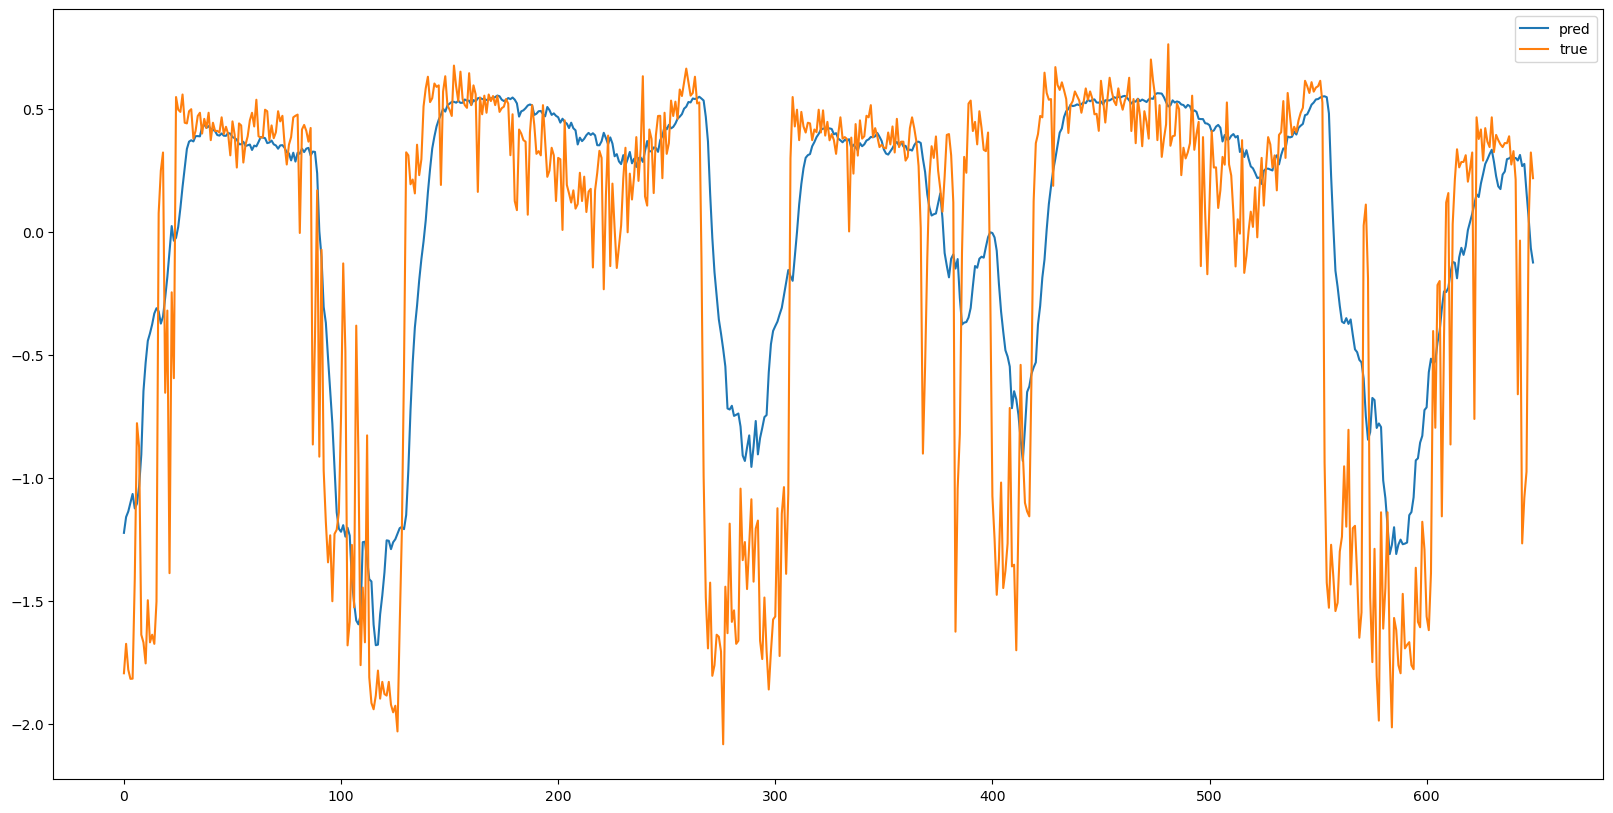

In [10]:
plt.figure(figsize=(20,10))
plt.plot(preds, label="pred")
plt.plot(labs, label="true")
plt.legend()
plt.savefig('sensor_eg1.png')
plt.show()

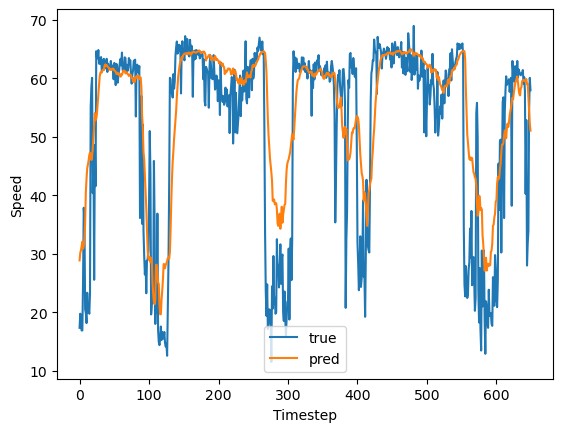

In [11]:
unnorm_preds = preds*20.209+53.59
unnorm_labs = labs*20.209+53.59
plt.plot(unnorm_labs, label="true")
plt.plot(unnorm_preds, label="pred")
plt.xlabel('Timestep')
plt.ylabel('Speed')
plt.legend()
plt.savefig('sensor_eg1.png')
plt.show()

In [12]:
preds = np.asarray([pred.detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label.cpu().numpy() for label in labels])
np.mean(np.abs(labs - preds))*20.209+53.59

62.21112284719944